In [464]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import random
from contextualized.easy import ContextualizedRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [465]:
# Set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Parameters
n_stocks = 100
n_quarters = 20
industries = ["Tech", "Energy", "Finance", "Healthcare", "Utilities"]

# Define IDs
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_quarters))
industry_map = {stock: np.random.choice(industries) for stock in stocks}

# Panel setup
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Assign industries
df["industry"] = df["stock_id"].map(industry_map)

# Simulate predictors
df["investment_spread"] = np.random.normal(0, 1, len(df))  # predictor 1
df["credit_growth"] = np.random.normal(0, 1, len(df))      # predictor 2

# Time context variable: uncertainty index (e.g., economic uncertainty)
uncertainty_index = {q: np.random.uniform(0.5, 1.5) for q in quarters}
df["uncertainty_index"] = df["quarter"].map(uncertainty_index)

# Simulate a smooth recession signal (e.g., from -1 to 2)
recession_index = np.sin(np.linspace(0, 3 * np.pi, n_quarters)) + np.random.normal(0, 0.2, n_quarters)
recession_index = {q: recession_index[q] for q in quarters}
df["recession_index"] = df["quarter"].map(recession_index)

# Stock context variable: industry bias
industry_bias = {
    "Tech": 2.0,
    "Energy": 1.0,
    "Finance": 1.5,
    "Healthcare": 1.2,
    "Utilities": 0.8
}
df["industry_bias"] = df["industry"].map(industry_bias) + np.random.normal(0, 0.1, len(df))

# Simulated volatility per stock
volatility_map = {stock: np.random.normal(0, 1) for stock in stocks}
df["volatility_score"] = df["stock_id"].map(volatility_map)


# Homogeneous context effect (bias)
df["bias"] = 0.8 * df["volatility_score"]* df["volatility_score"]+ (1 - df["recession_index"])*df["industry_bias"] + np.random.normal(0, 0.1, len(df))


# Slope modulated by true (but hidden) context interaction
df["credit_slope"] = 0.4 + 1.5*np.log(df["uncertainty_index"]) + np.random.normal(0, 0.1, len(df))

# Return generation
df["return"] = (
    -1.0 * df["investment_spread"]  # homogeneous
    + df["credit_slope"] * df["credit_growth"]  # hetero, context-modulated
    + df["bias"] # heterogenous context effect
    + np.random.normal(0, 0.1, len(df))  # overall noise
)


# Convert to panel format
df = df.set_index(["stock_id", "quarter"])
df.head(30)



industry  investment_spread  credit_growth  \
stock_id quarter                                                 
Stock_0  0        Healthcare          -0.896335       0.382255   
         1        Healthcare          -0.111988      -0.803977   
         2        Healthcare           1.468941       2.241135   
         3        Healthcare          -1.123898      -0.410281   
         4        Healthcare           0.950005      -2.425214   
         5        Healthcare           1.726516      -0.030172   
         6        Healthcare           0.457885      -0.073033   
         7        Healthcare          -1.684287       1.111719   
         8        Healthcare           0.326845       0.288126   
         9        Healthcare          -0.081119      -0.833835   
         10       Healthcare           0.467795      -0.286392   
         11       Healthcare           0.736122       0.327420   
         12       Healthcare          -0.779702      -2.164714   
         13       Healthcare          -0.843896       1.338622   
         14       Healthcare          -0.150534      -0.831170   
         15       Healthcare          -0.965558       1.417044   
         16       Healthcare           0.150489       0.392465   
         17       Healthcare          -0.113421       0.629594   
         18       Healthcare           2.633528       1.149423   
         19       Healthcare          -1.025091       0.573132   
Stock_1  0         Utilities          -0.782048       0.672886   
         1         Utilities           0.423943      -0.164416   
         2         Utilities           0.872705       0.372169   
         3         Utilities           2.287226      -0.587498   
         4         Utilities           1.622920      -0.343411   
         5         Utilities           0.823733       1.964695   
         6         Utilities           0.293059      -0.808194   
         7         Utilities           0.896630       0.154317   
         8         Utilities          -0.610322       0.113469   
         9         Utilities          -0.316166      -0.310754   

                  uncertainty_index  recession_index  industry_bias  \
stock_id quarter                                                      
Stock_0  0                 1.243435        -0.322404       1.334888   
         1                 1.032827         0.320124       1.349770   
         2                 1.360668         0.628338       1.176817   
         3                 1.194918         1.072505       1.067380   
         4                 0.510551         0.668701       1.336647   
         5                 0.894090         0.506370       1.194813   
         6                 1.350952         0.227505       1.184103   
         7                 0.845859        -0.296970       1.110715   
         8                 0.535215        -0.738253       1.075011   
         9                 1.246180        -0.944200       1.256386   
         10                1.302038        -1.043500       1.266987   
         11                0.660594        -1.056474       1.220154   
         12                1.037340        -0.404067       1.123595   
         13                0.691955         0.258345       1.093500   
         14                1.219234         0.586826       1.056775   
         15                0.771550         0.994071       1.143945   
         16                0.816215         0.879228       1.099415   
         17                1.344971         1.036034       1.029069   
         18                0.976322        -0.035316       1.265135   
         19                1.169754         0.028288       1.068094   
Stock_1  0                 1.243435        -0.322404       0.898392   
         1                 1.032827         0.320124       0.839407   
         2                 1.360668         0.628338       0.829434   
         3                 1.194918         1.072505       0.966531   
         4                 0.510551         0.668701       0.

In [466]:
df["credit_slope"].mean()

0.4666783863775966

In [467]:
# Run the fixed effects model
fixed_effects_model = PanelOLS(
    dependent=df["return"],
    exog=df[["investment_spread", "credit_growth"]],
    entity_effects=True,
    time_effects=True
)
results = fixed_effects_model.fit(cov_type="clustered", cluster_entity=True)

# Print summary
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.8598
Estimator:                   PanelOLS   R-squared (Between):             -0.0127
No. Observations:                2000   R-squared (Within):               0.5810
Date:                Tue, Apr 22 2025   R-squared (Overall):              0.1553
Time:                        23:49:01   Log-likelihood                   -1222.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5761.9
Entities:                         100   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(2,1879)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             5555.1
                            

In [468]:
# Predictions
df["predicted_return"] = results.predict().fitted_values
df_reset = df.reset_index()

df.head(25)

industry  investment_spread  credit_growth  \
stock_id quarter                                                 
Stock_0  0        Healthcare          -0.896335       0.382255   
         1        Healthcare          -0.111988      -0.803977   
         2        Healthcare           1.468941       2.241135   
         3        Healthcare          -1.123898      -0.410281   
         4        Healthcare           0.950005      -2.425214   
         5        Healthcare           1.726516      -0.030172   
         6        Healthcare           0.457885      -0.073033   
         7        Healthcare          -1.684287       1.111719   
         8        Healthcare           0.326845       0.288126   
         9        Healthcare          -0.081119      -0.833835   
         10       Healthcare           0.467795      -0.286392   
         11       Healthcare           0.736122       0.327420   
         12       Healthcare          -0.779702      -2.164714   
         13       Healthcare          -0.843896       1.338622   
         14       Healthcare          -0.150534      -0.831170   
         15       Healthcare          -0.965558       1.417044   
         16       Healthcare           0.150489       0.392465   
         17       Healthcare          -0.113421       0.629594   
         18       Healthcare           2.633528       1.149423   
         19       Healthcare          -1.025091       0.573132   
Stock_1  0         Utilities          -0.782048       0.672886   
         1         Utilities           0.423943      -0.164416   
         2         Utilities           0.872705       0.372169   
         3         Utilities           2.287226      -0.587498   
         4         Utilities           1.622920      -0.343411   

                  uncertainty_index  recession_index  industry_bias  \
stock_id quarter                                                      
Stock_0  0                 1.243435        -0.322404       1.334888   
         1                 1.032827         0.320124       1.349770   
         2                 1.360668         0.628338       1.176817   
         3                 1.194918         1.072505       1.067380   
         4                 0.510551         0.668701       1.336647   
         5                 0.894090         0.506370       1.194813   
         6                 1.350952         0.227505       1.184103   
         7                 0.845859        -0.296970       1.110715   
         8                 0.535215        -0.738253       1.075011   
         9                 1.246180        -0.944200       1.256386   
         10                1.302038        -1.043500       1.266987   
         11                0.660594        -1.056474       1.220154   
         12                1.037340        -0.404067       1.123595   
         13                0.691955         0.258345       1.093500   
         14                1.219234         0.586826       1.056775   
         15                0.771550         0.994071       1.143945   
         16                0.816215         0.879228       1.099415   
         17                1.344971         1.036034       1.029069   
         18                0.976322        -0.035316       1.265135   
         19                1.169754         0.028288       1.068094   
Stock_1  0                 1.243435        -0.322404       0.898392   
         1                 1.032827         0.320124       0.839407   
         2                 1.360668         0.628338       0.829434   
         3                 1.194918         1.072505       0.966531   
         4                 0.510551         0.668701       0.671420   

                  volatility_score      bias  credit_slope    return  \
stock_id quarter                                                       
Stock_0  0                0.709773  2.172339      0.670389  3.365954   
         1                0.709773  1.294389      0.462337  0.929801   
         2                0.709

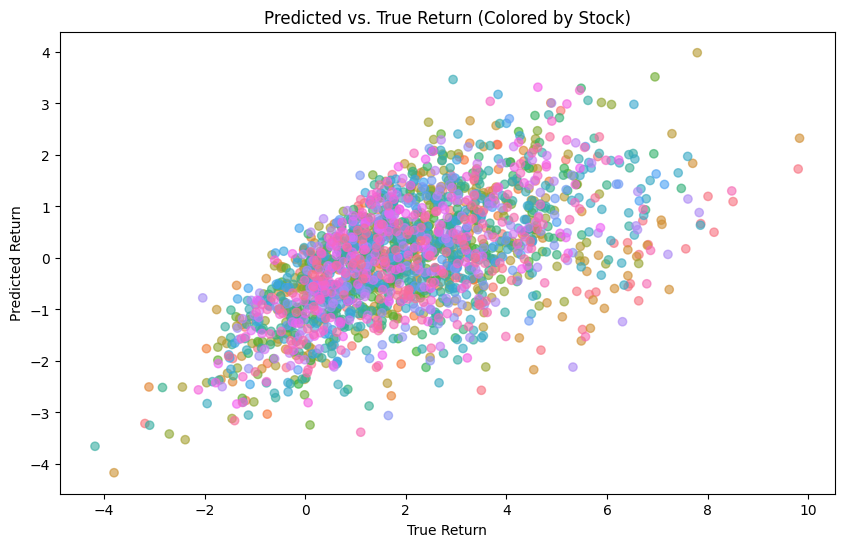

In [469]:
df = df.reset_index()

import seaborn as sns
# Create a color palette for stocks
unique_stocks = df["stock_id"].unique()
palette = sns.color_palette("husl", len(unique_stocks))  # bright, distinct colors
stock_color_map = dict(zip(unique_stocks, palette))

# Map stock_id to colors
colors = df["stock_id"].map(stock_color_map)

# Plot with colored points
plt.figure(figsize=(10, 6))
plt.scatter(df["return"], df["predicted_return"], c=colors, alpha=0.6)
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.title("Predicted vs. True Return (Colored by Stock)")
plt.show()

In [470]:
from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(df["return"], df["predicted_return"])}')
print(f'Correlation: {r2_score(df["return"], df["predicted_return"])}')

Mean-squared Error: 6.766570784990725
Correlation: -0.7801250338179426


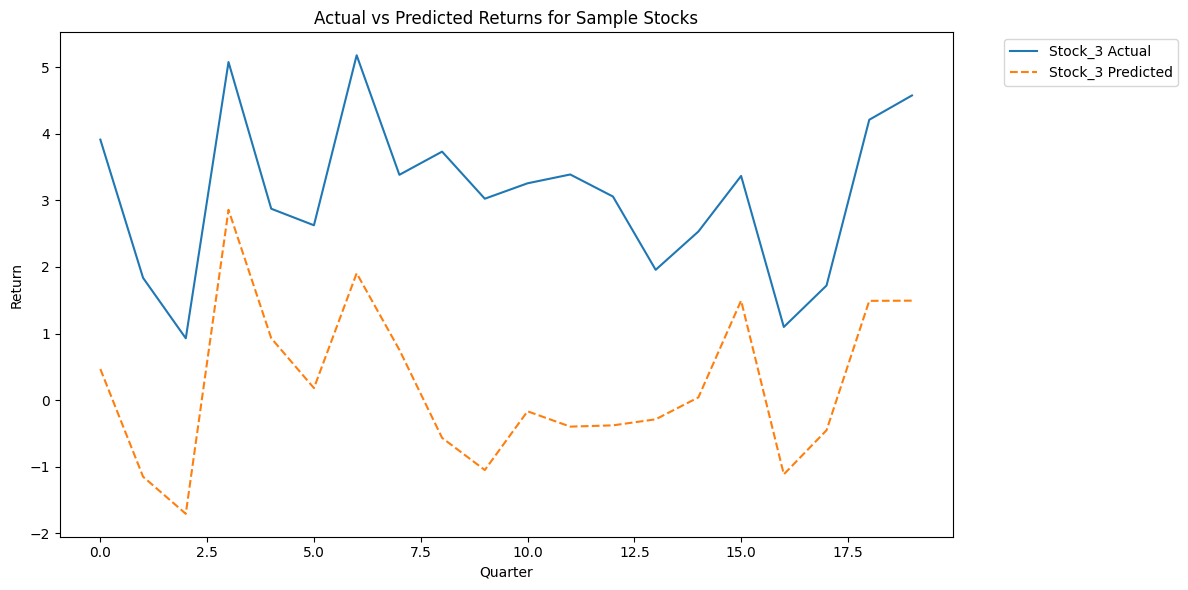

In [471]:
# Plot for first 5 stocks
fig, ax = plt.subplots(figsize=(12, 6))
sample_stocks = df_reset["stock_id"].unique()[3:4]

for stock in sample_stocks:
    stock_data = df_reset[df_reset["stock_id"] == stock]
    ax.plot(stock_data["quarter"], stock_data["return"], label=f"{stock} Actual", linestyle='-')
    ax.plot(stock_data["quarter"], stock_data["predicted_return"], label=f"{stock} Predicted", linestyle='--')

ax.set_title("Actual vs Predicted Returns for Sample Stocks")
ax.set_xlabel("Quarter")
ax.set_ylabel("Return")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [472]:
df = df.reset_index()

# Average return per industry
avg_return_by_industry = df.groupby("industry")["return"].mean().to_dict()
# Map to each row
df["industry_avg_return"] = df["industry"].map(avg_return_by_industry)


C = df[["uncertainty_index", "recession_index", "industry_avg_return", "volatility_score"]].values
X = df[["investment_spread", "credit_growth"]].values
Y = df["return"].values.reshape(-1, 1)




In [473]:
# Define test period as last 4 quarters
test_quarters = [16, 17, 18, 19]

# Mask for test and train sets
test_mask = df["quarter"].isin(test_quarters)
train_mask = ~test_mask

# Split context, predictors, and targets accordingly
C_train = C[train_mask.values]
C_test  = C[test_mask.values]

X_train = X[train_mask.values]
X_test  = X[test_mask.values]

Y_train = Y[train_mask.values]
Y_test  = Y[test_mask.values]


def normalize(train, test):
    mean = train.mean(axis=0)
    std = train.std(axis=0)
    return (train - mean) / std, (test - mean) / std

X_train, X_test = normalize(X_train, X_test)
C_train, C_test = normalize(C_train, C_test)
Y_train, Y_test = normalize(Y_train, Y_test)

In [474]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

Y_pred_linear = linear_model.predict(X_test)

In [475]:
X_C_train = np.concatenate([X_train, C_train], axis=1)
X_C_test = np.concatenate([X_test, C_test], axis=1)

linear_model_with_context = LinearRegression()
linear_model_with_context.fit(X_C_train, Y_train)

Y_pred_linear_with_context = linear_model_with_context.predict(X_C_test)

In [476]:
model = ContextualizedRegressor(n_bootstraps=25, alpha=0.1)
model.fit(C_train, X_train, Y_train,
          encoder_type="mlp",
          max_epochs=10,
          learning_rate=1e-2)

contextualized_coeffs, contextualized_offsets = model.predict_params(C)
Y_pred = model.predict(C_test, X_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/lightning_logs/boot_0_checkpoints exists and is not empty.

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | metamodel | NaiveMetamodel | 1.5 K  | train
-----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck.

In [477]:
print(f'Mean-squared Error (Linear Model): {mean_squared_error(Y_test, Y_pred_linear)}')
print(f'Correlation (Linear Model): {r2_score(Y_test, Y_pred_linear)}')

print(f'Mean-squared Error (Linear Model with Context): {mean_squared_error(Y_test, Y_pred_linear_with_context)}')
print(f'Correlation (Linear Model): {r2_score(Y_test, Y_pred_linear_with_context)}')

print(f'Mean-squared Error: {mean_squared_error(Y_test, Y_pred)}')
print(f'Correlation: {r2_score(Y_test, Y_pred)}')

Mean-squared Error (Linear Model): 0.6027955245103321
Correlation (Linear Model): 0.3239177531367856
Mean-squared Error (Linear Model with Context): 0.37430020046029466
Correlation (Linear Model): 0.5801930999170681
Mean-squared Error: 0.05401998192849646
Correlation: 0.9394123724004156


In [478]:
contextualized_coeffs, contextualized_offsets

(array([[[-0.48465151,  0.20069791]],
 
        [[-0.48476537,  0.2294437 ]],
 
        [[-0.49275443,  0.24918617]],
 
        ...,
 
        [[-0.51823623,  0.265622  ]],
 
        [[-0.49601744,  0.2202996 ]],
 
        [[-0.49960466,  0.23039563]]]),
 array([[ 0.44573451],
        [ 0.07328305],
        [-0.09269592],
        ...,
        [-0.56604871],
        [ 0.02349461],
        [-0.00781833]]))

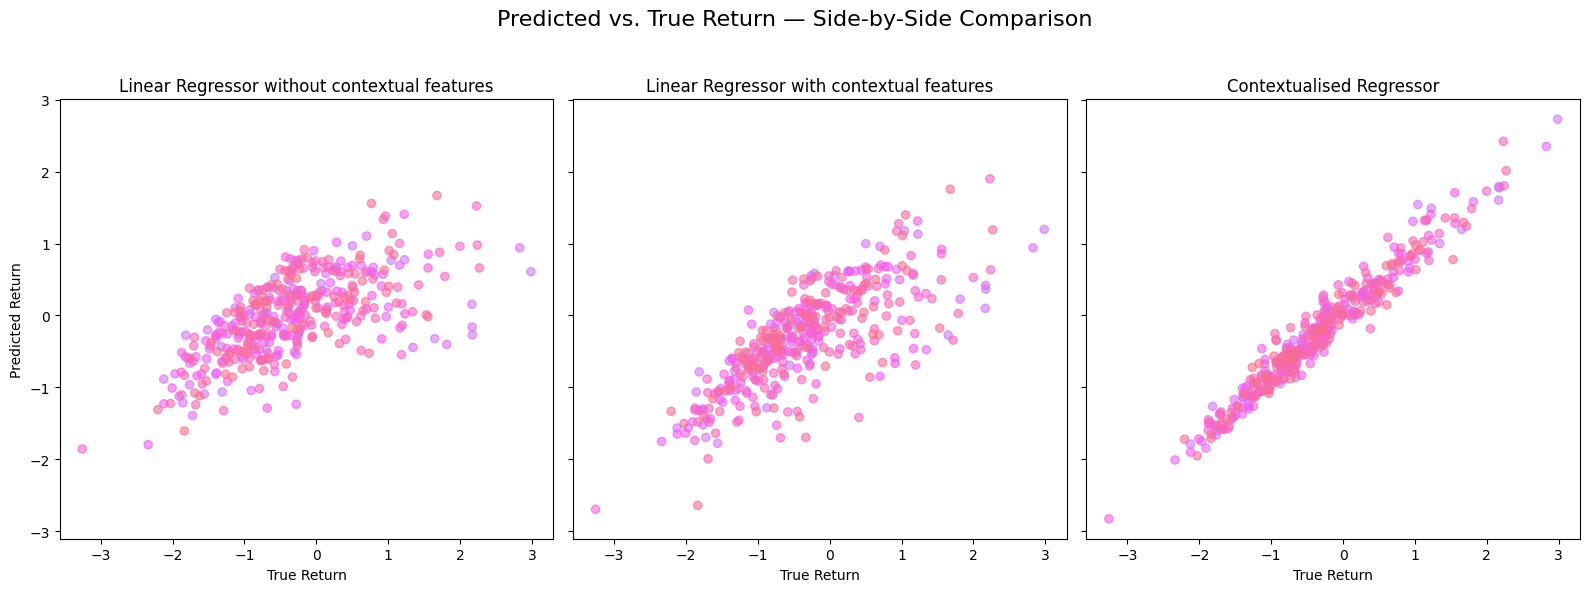

In [479]:
colors_test = colors[-400:]

# Example: comparing two models (or just showing the same model twice)
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

# First plot (linear model)
axs[0].scatter(Y_test, Y_pred_linear, c=colors_test, alpha=0.6)
axs[0].set_title("Linear Regressor without contextual features")
axs[0].set_xlabel("True Return")
axs[0].set_ylabel("Predicted Return")

# Second plot (linear model with context)
axs[1].scatter(Y_test, Y_pred_linear_with_context, c=colors_test, alpha=0.6)
axs[1].set_title("Linear Regressor with contextual features")
axs[1].set_xlabel("True Return")
axs[1].set_ylabel("")

# Second plot (Contextualised Regressor)
axs[2].scatter(Y_test, Y_pred, c=colors_test, alpha=0.6)
axs[2].set_title("Contextualised Regressor")
axs[2].set_xlabel("True Return")
axs[2].set_ylabel("")

plt.suptitle("Predicted vs. True Return — Side-by-Side Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


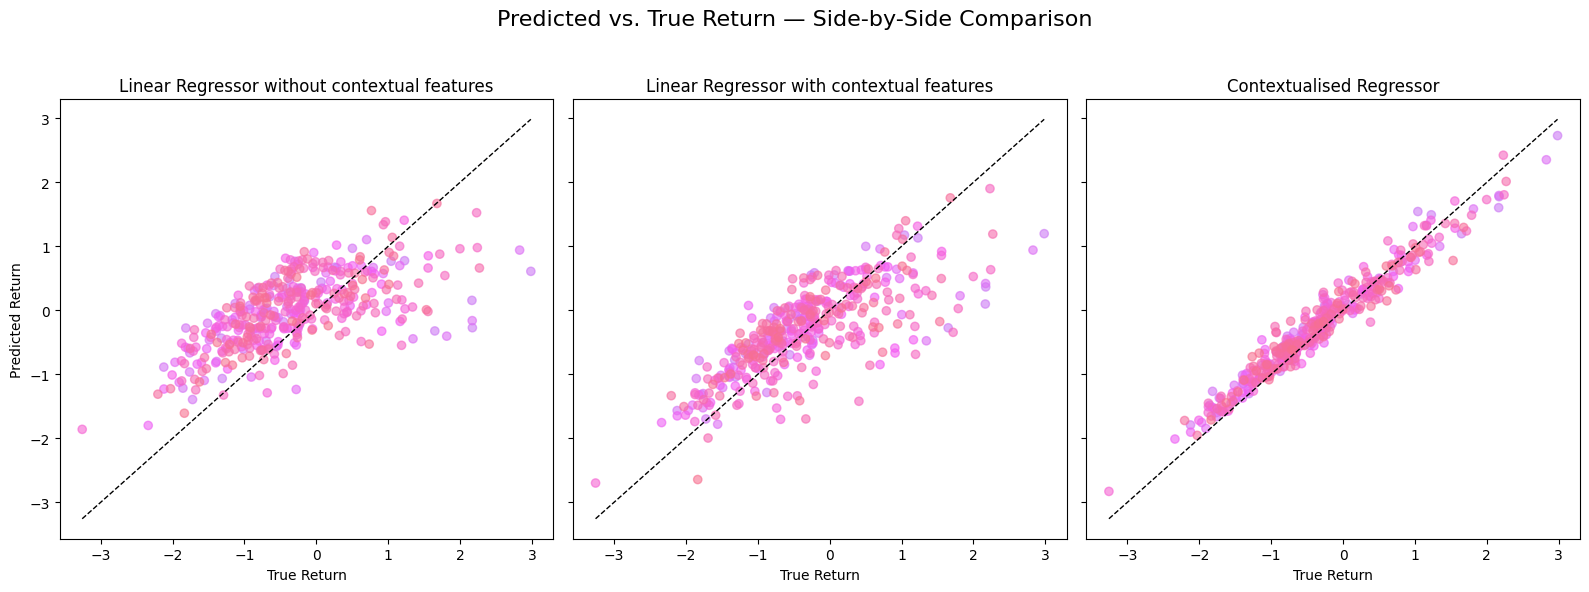

In [480]:
colors_test = colors[-400:]

# Example: comparing two models (or just showing the same model twice)
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

# Define line range (diagonal for perfect prediction)
min_val = min(Y_test.min(), Y_pred.min(), Y_pred_linear.min(), Y_pred_linear_with_context.min())
max_val = max(Y_test.max(), Y_pred.max(), Y_pred_linear.max(), Y_pred_linear_with_context.max())

# First plot (linear model)
axs[0].scatter(Y_test, Y_pred_linear, c=colors_test, alpha=0.6)
axs[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)  # perfect line
axs[0].set_title("Linear Regressor without contextual features")
axs[0].set_xlabel("True Return")
axs[0].set_ylabel("Predicted Return")

# Second plot (linear model with context)
axs[1].scatter(Y_test, Y_pred_linear_with_context, c=colors_test, alpha=0.6)
axs[1].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)
axs[1].set_title("Linear Regressor with contextual features")
axs[1].set_xlabel("True Return")
axs[1].set_ylabel("")

# Third plot (Contextualised Regressor)
axs[2].scatter(Y_test, Y_pred, c=colors_test, alpha=0.6)
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)
axs[2].set_title("Contextualised Regressor")
axs[2].set_xlabel("True Return")
axs[2].set_ylabel("")

plt.suptitle("Predicted vs. True Return — Side-by-Side Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [481]:
%%capture
coefs, offsets = model.predict_params(C, individual_preds=False)
coefs.shape # (n_samples, n_outputs, n_predictors)
offsets.shape  # (n_samples, n_outputs)

# Contextualized linear regression coefficients are shape:
# (n_samples, n_outputs, n_predictors)
# Let's squeeze out the n_outputs axis since we only have 1 output in this example.
coefs = np.squeeze(coefs)


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
model_reps = pca.fit_transform(coefs)

C = pd.DataFrame(C, columns=["uncertainty_index", "recession_index", "industry_avg_return", "volatility_score"])
X = pd.DataFrame(X, columns=["investment_spread", "credit_growth"])

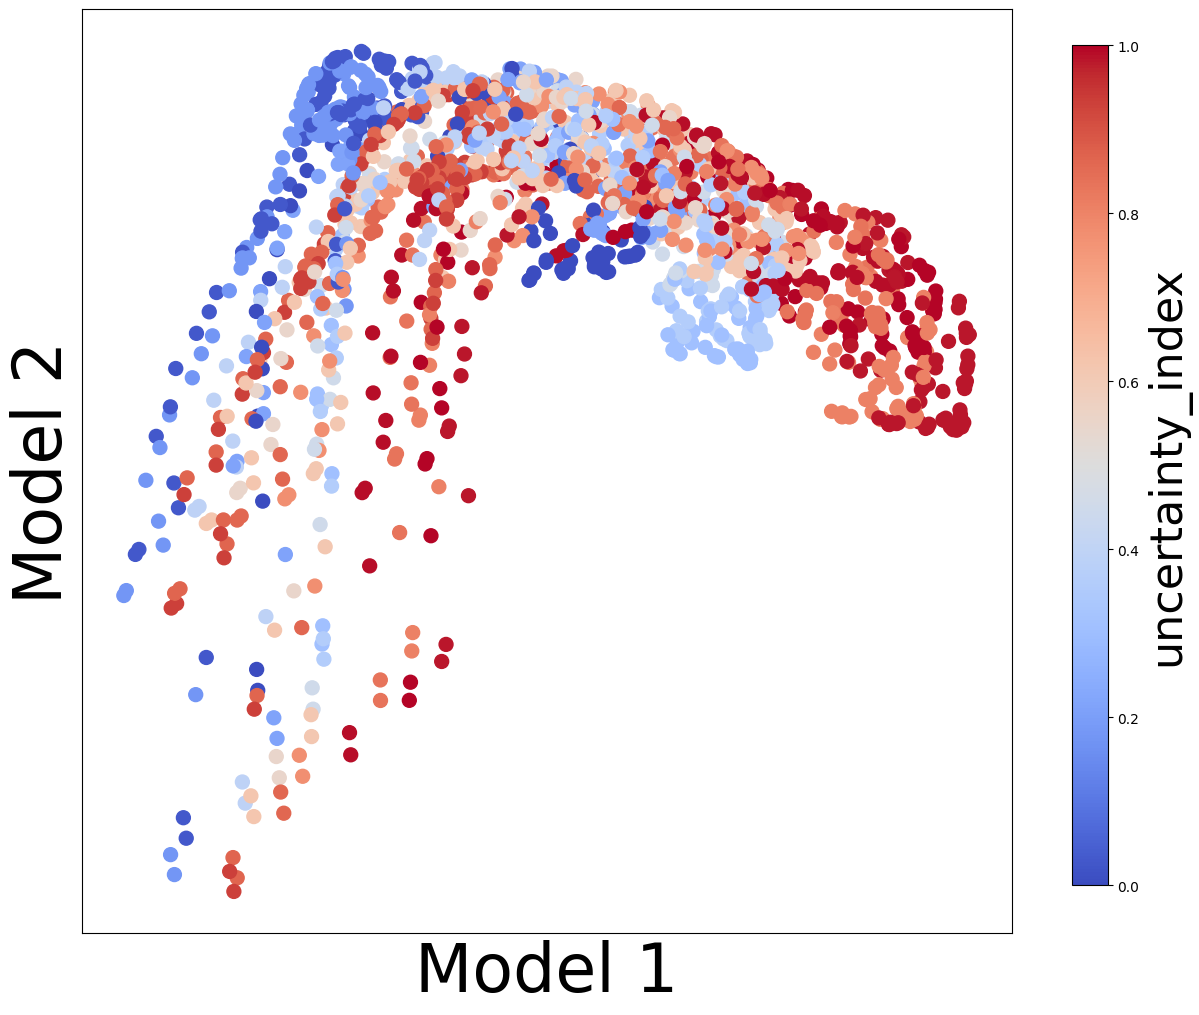

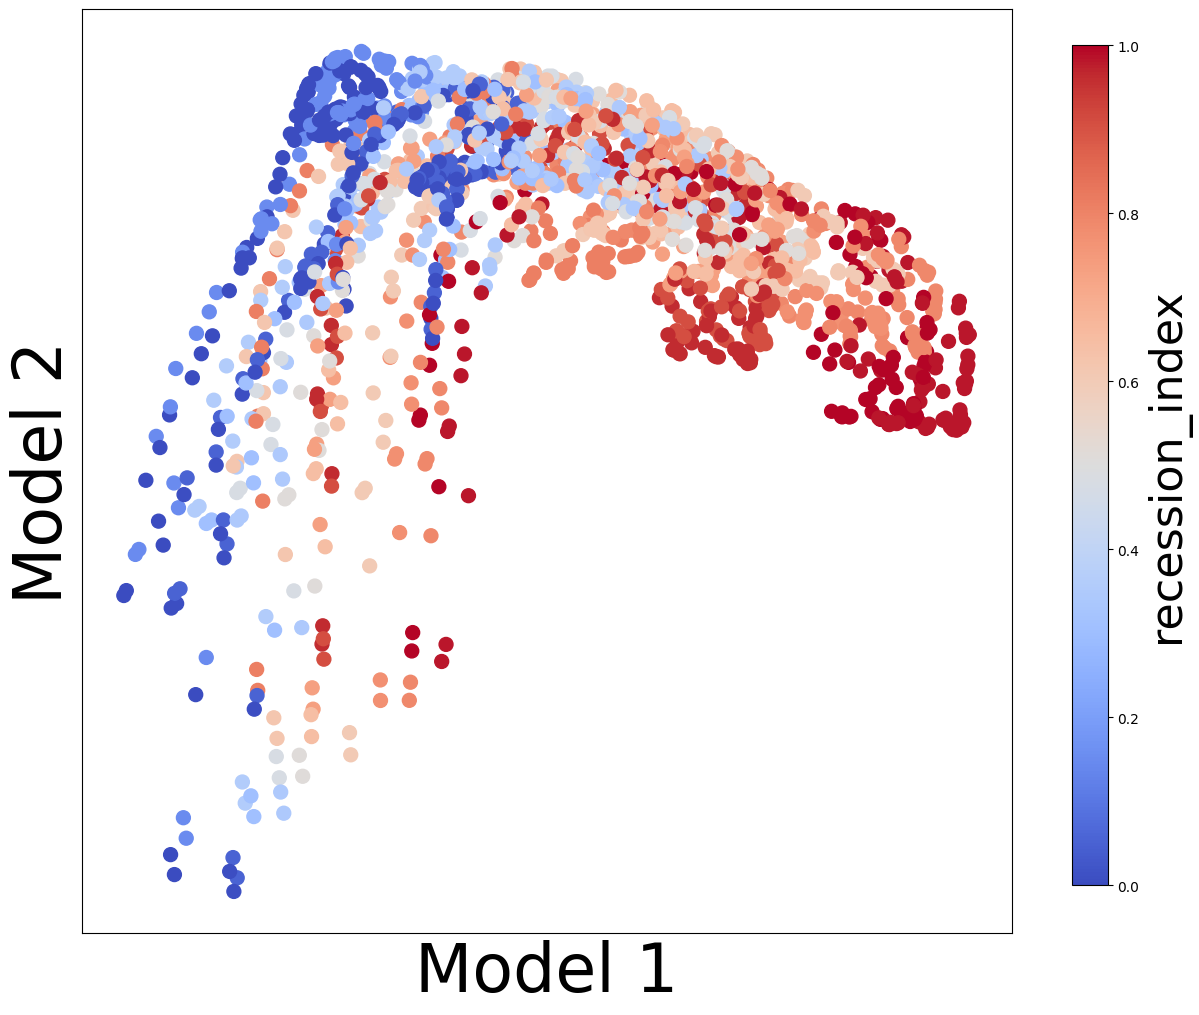

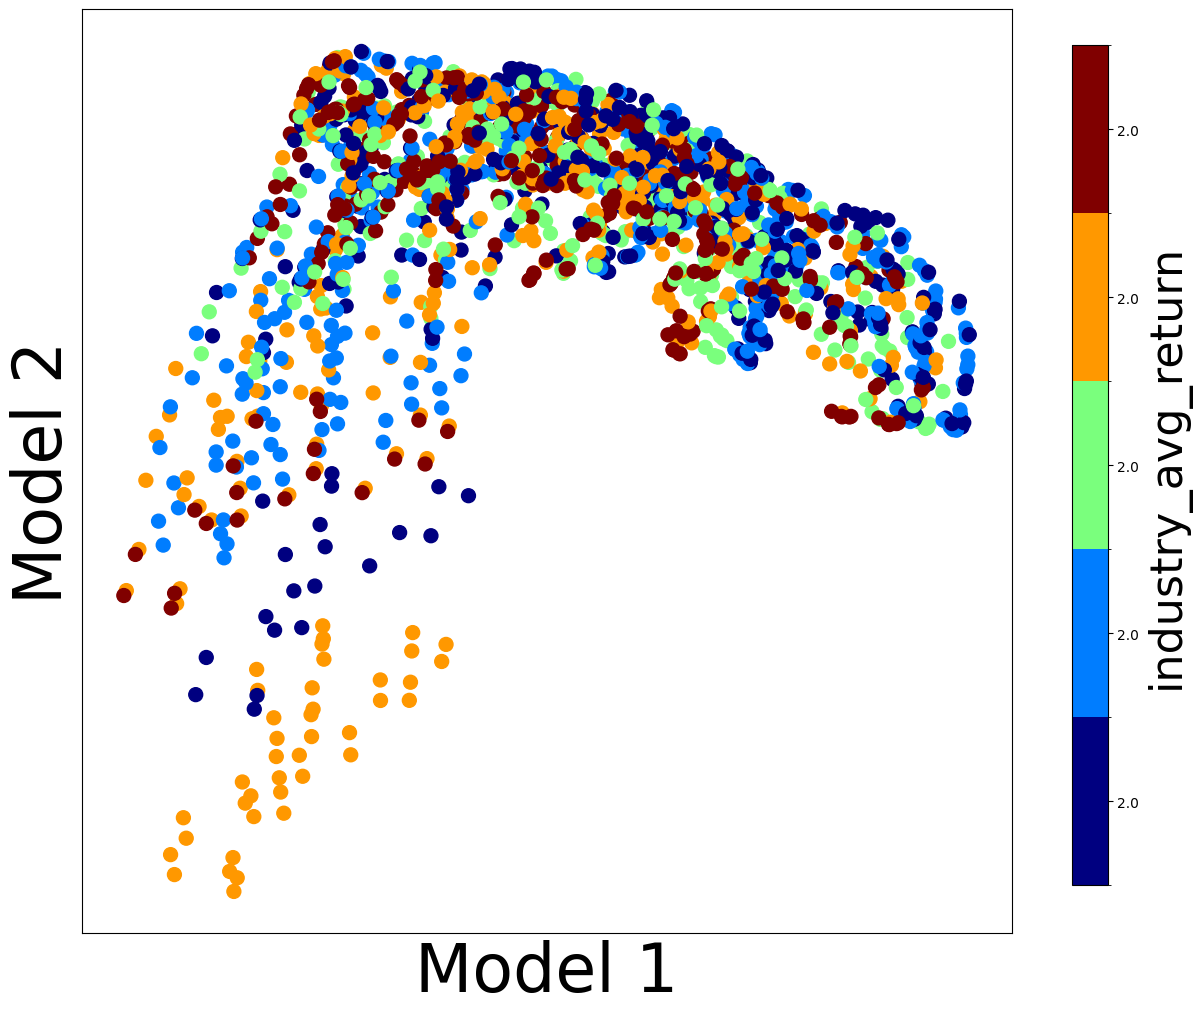

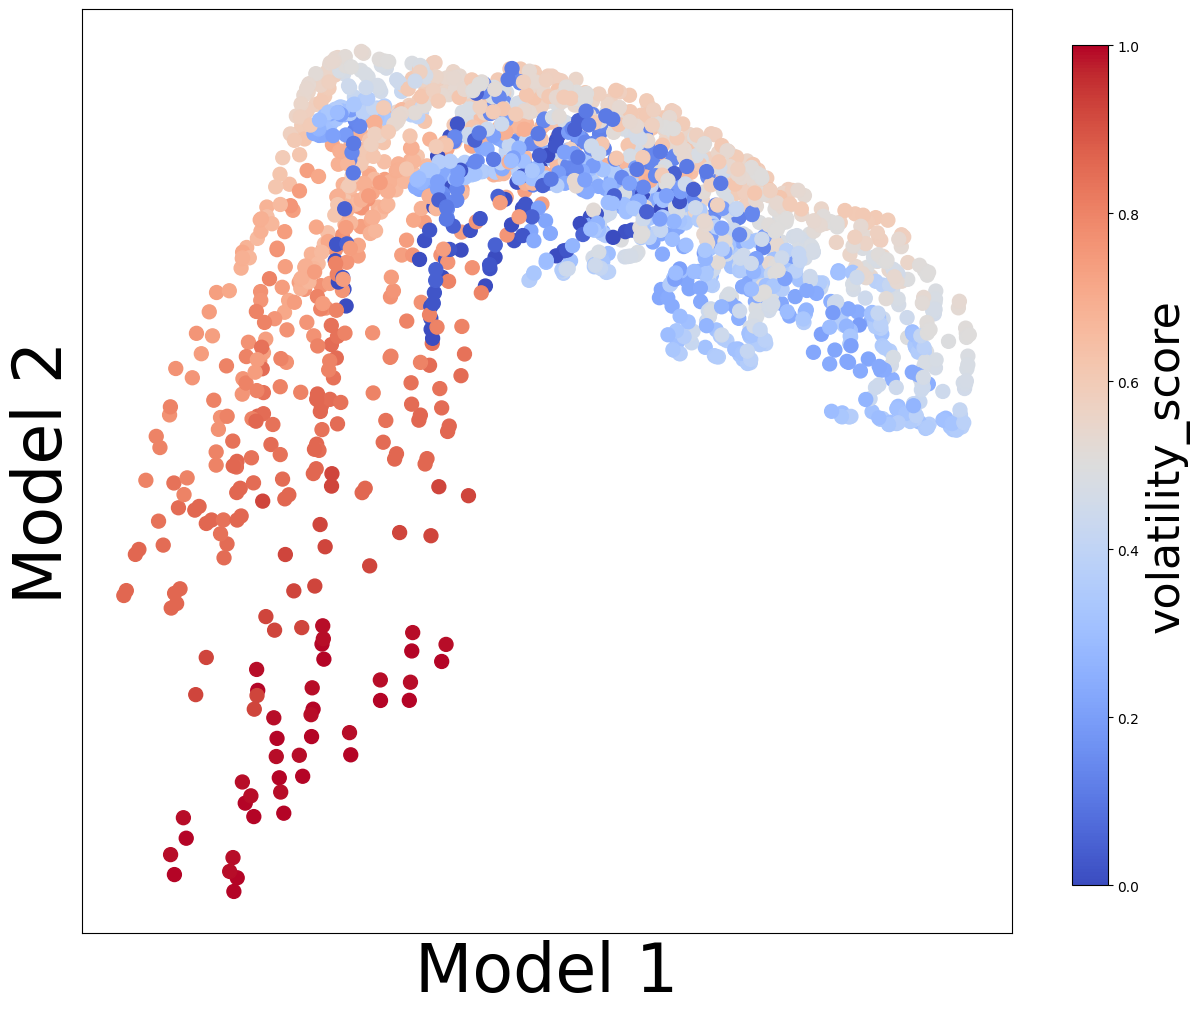

In [482]:
# A simple helper function is provided in the analysis toolkit for plotting embeddings.
from contextualized.analysis.embeddings import plot_embedding_for_all_covars
plot_embedding_for_all_covars(model_reps, C, xlabel='Model 1', ylabel='Model 2')

In [483]:
from contextualized.analysis.effects import (
    plot_homogeneous_context_effects,
    plot_homogeneous_predictor_effects,
    plot_heterogeneous_predictor_effects,
)

from contextualized.analysis.pvals import (
    calc_homogeneous_context_effects_pvals,
    calc_homogeneous_predictor_effects_pvals,
    calc_heterogeneous_predictor_effects_pvals
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


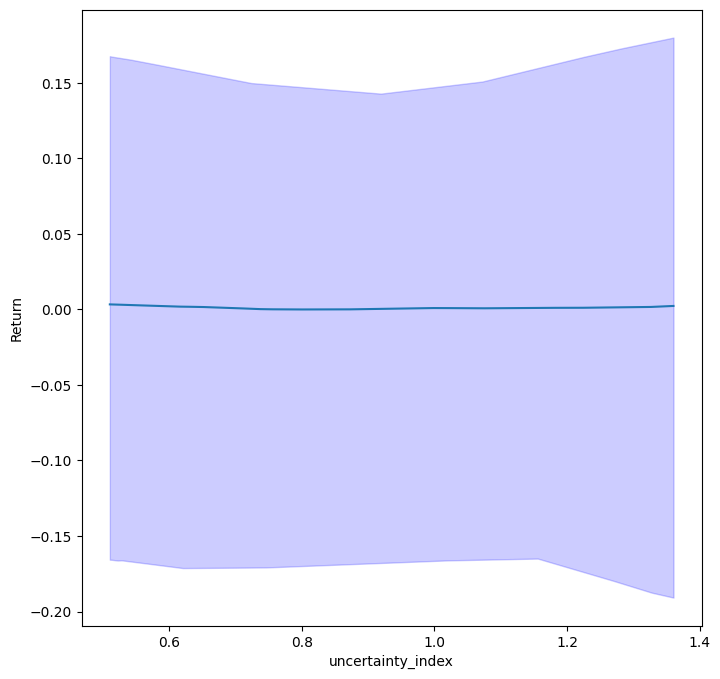

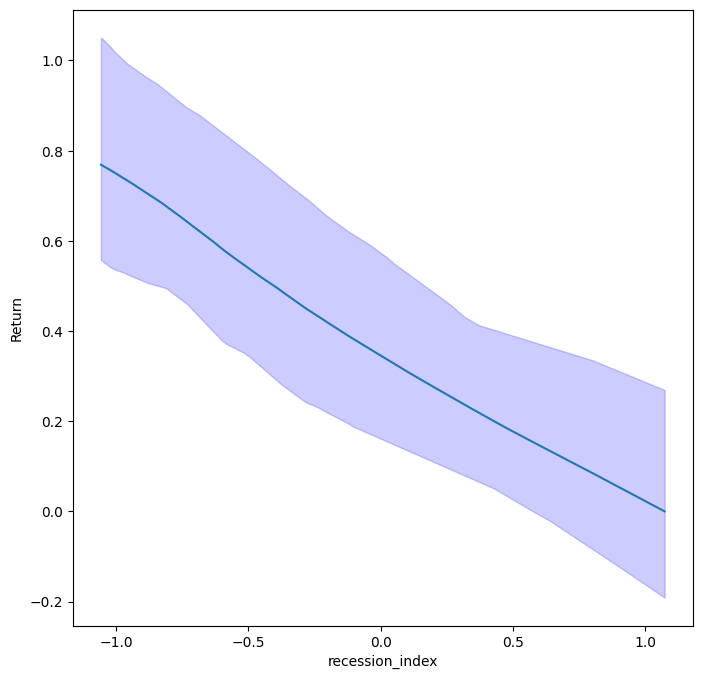

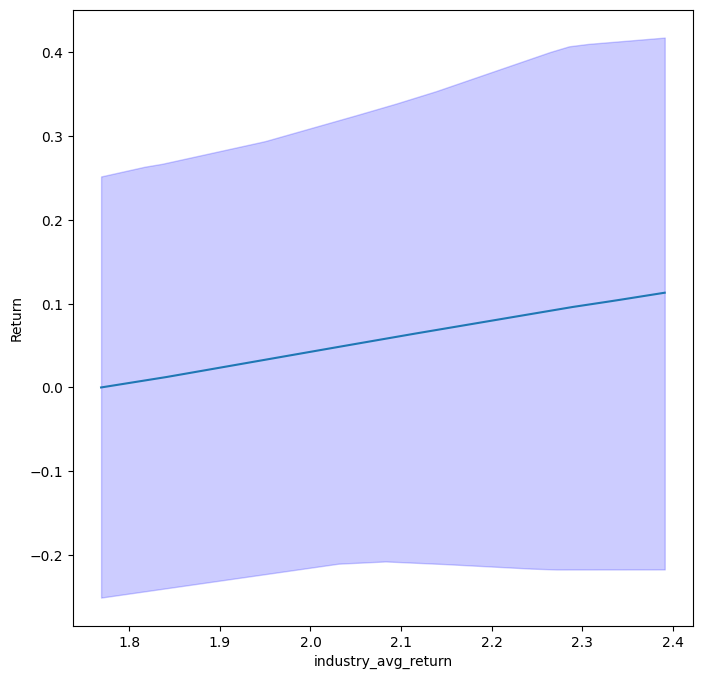

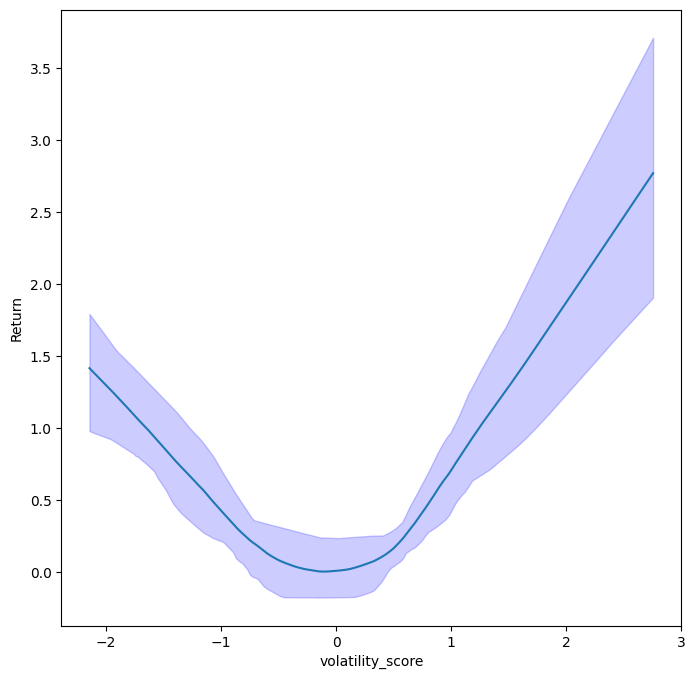

In [484]:
plot_homogeneous_context_effects(
    model, C, classification=False,
    ylabel="Return", verbose=False)

In [485]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
homogeneous_context_pvals = calc_homogeneous_context_effects_pvals(model, C)
context_pvals = pd.DataFrame(np.array([
   [C.columns[i], pval[0]] for i, pval in enumerate(homogeneous_context_pvals)
]), columns=["Context Variable", "p-value"])

In [486]:
context_pvals
# Notice that the p-values are calculated from bootstrap resampling,
# so they are limited by the number of bootstraps used.
# Caution: using more bootstraps could artificially inflate confidence.

,Context Variable,p-value
0,uncertainty_index,0.5384615384615384
1,recession_index,0.038461538461538464
2,industry_avg_return,0.07692307692307693
3,volatility_score,0.038461538461538464


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


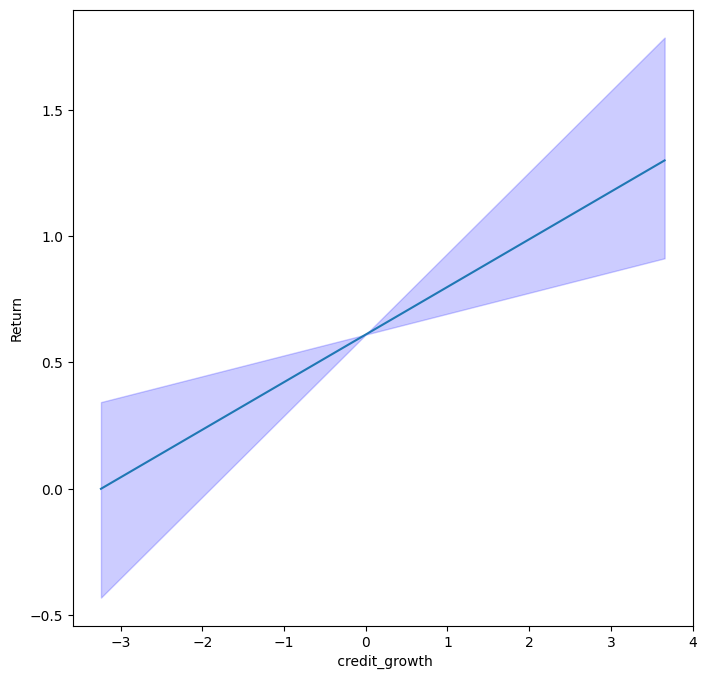

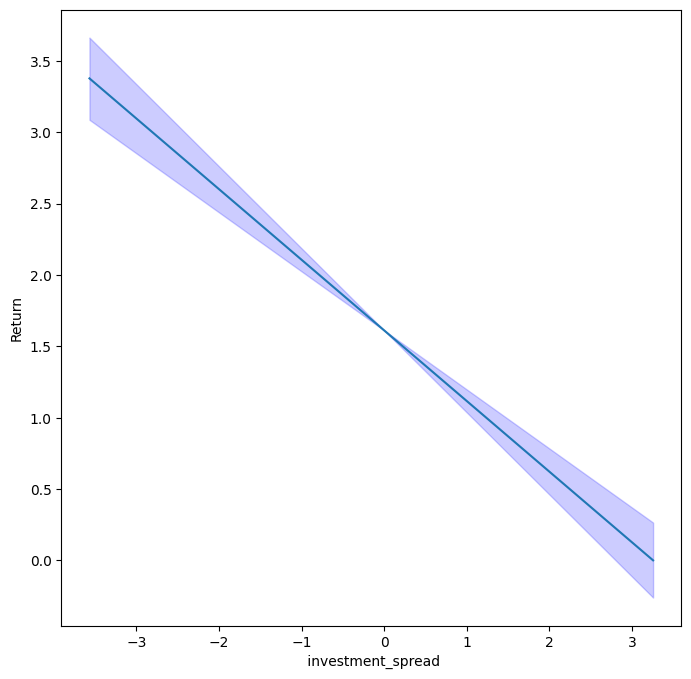

In [487]:
plot_homogeneous_predictor_effects(
    model, C, X,
    ylabel="Return",
    classification=False)

In [488]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
homogeneous_predictor_pvals = calc_homogeneous_predictor_effects_pvals(model, C)
predictor_pvals = pd.DataFrame(np.array([
   [X.columns[i], pval[0]] for i, pval in enumerate(homogeneous_predictor_pvals)
]), columns=["Predictor", "p-value"])

In [489]:
predictor_pvals

,Predictor,p-value
0,investment_spread,0.038461538461538464
1,credit_growth,0.07692307692307693


Generating datapoints for visualization by assuming the encoder is
            an additive model and thus doesn't require sampling on a manifold.
            If the encoder has interactions, please supply C_vis so that we
            can visualize these effects on the correct data manifold.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


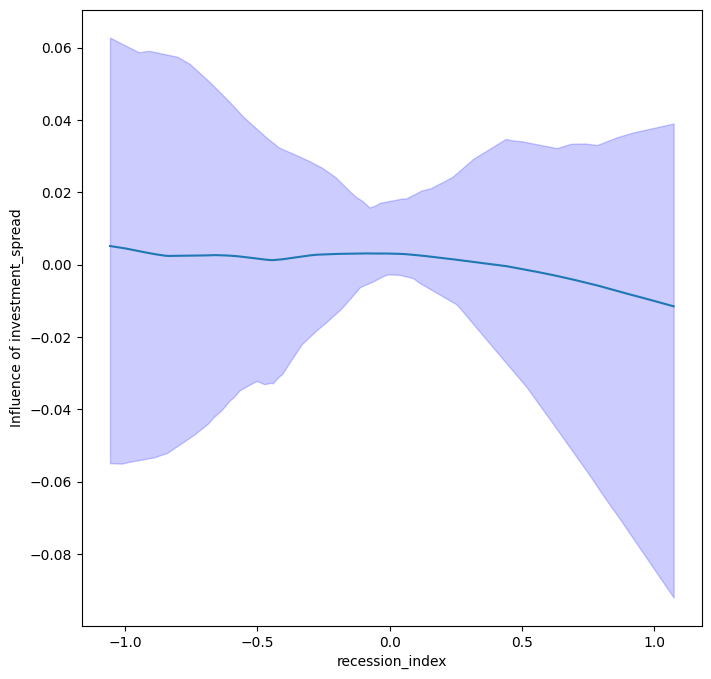

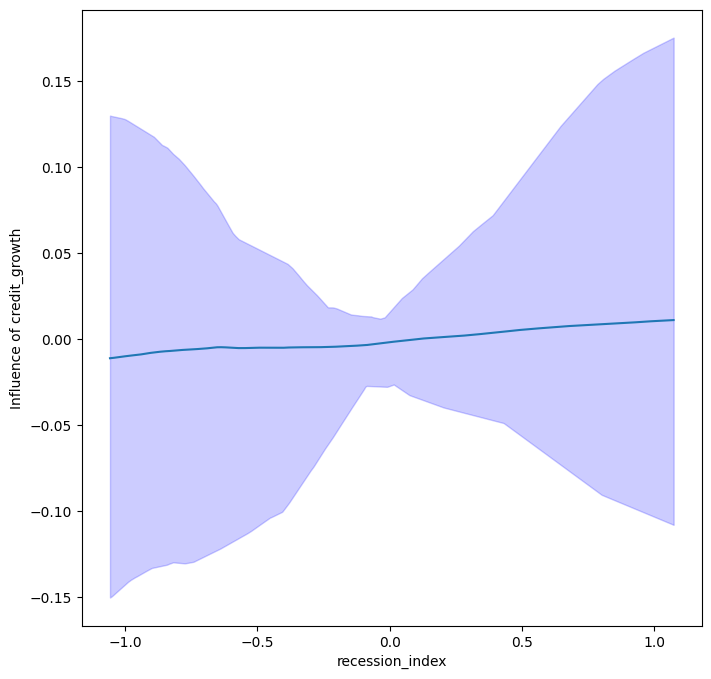

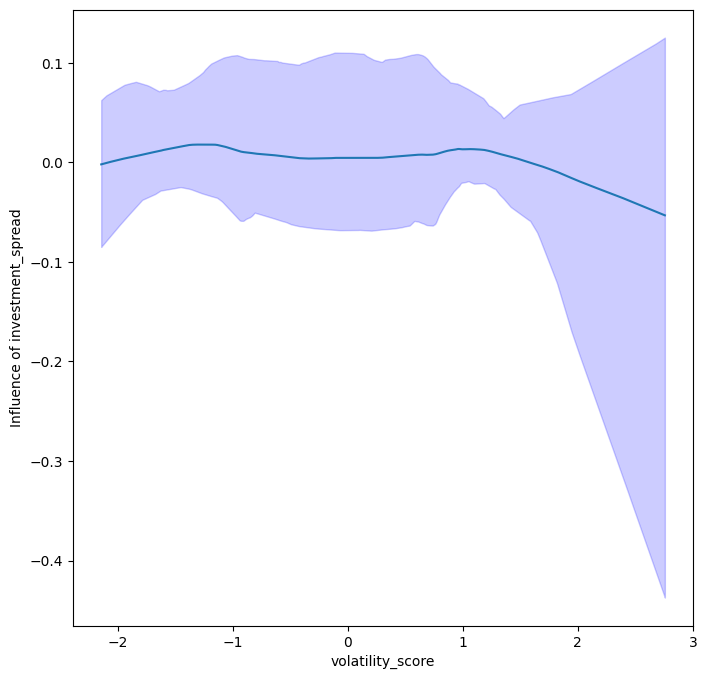

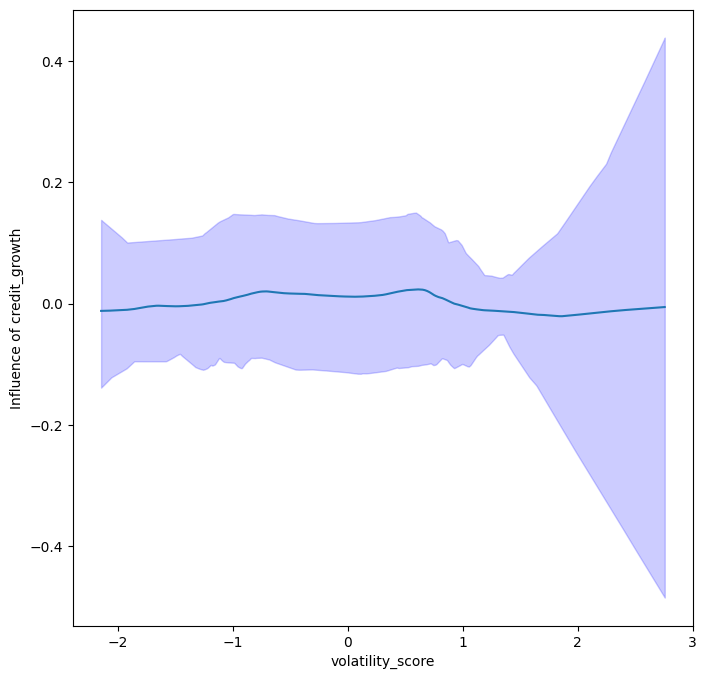

In [490]:
plot_heterogeneous_predictor_effects(model, C, X, min_effect_size=0.1,
                  ylabel="Influence of")
# Since there are a combinatorial number of heterogeneous predictor effects,
# min_effect_size is a useful parameter to restrict the plotting to
# only the strongest effects.

In [491]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
# This is a combinatorial: context x predictor
heterogeneous_predictor_pvals = calc_heterogeneous_predictor_effects_pvals(model, C)
predictor_pvals = pd.DataFrame(np.array([
   [C.columns[i // len(X.columns)], X.columns[i % len(X.columns)], pval] for i, pval in enumerate(heterogeneous_predictor_pvals.flatten())
]), columns=["Context", "Predictor", "p-value"])

In [492]:
predictor_pvals

,Context,Predictor,p-value
0,uncertainty_index,investment_spread,0.5
1,uncertainty_index,credit_growth,0.07692307692307693
2,recession_index,investment_spread,0.38461538461538464
3,recession_index,credit_growth,0.4230769230769231
4,industry_avg_return,investment_spread,0.4230769230769231
5,industry_avg_return,credit_growth,0.5384615384615384
6,volatility_score,investment_spread,0.34615384615384615
7,volatility_score,credit_growth,0.5
